<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/0_25_Drop_Adam_All_B32_0214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [ ]:

# Import necessary libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio

In [ ]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [ ]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 224
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [ ]:
train_X

array([[[[ 54,  65,  81],
         [ 51,  60,  77],
         [ 38,  50,  71],
         ...,
         [ 70,  93, 106],
         [ 66,  87, 105],
         [ 60,  82, 105]],

        [[ 59,  67,  81],
         [ 54,  63,  78],
         [ 52,  60,  77],
         ...,
         [ 75,  91, 103],
         [ 78,  95, 108],
         [ 71,  87, 105]],

        [[ 76,  82,  98],
         [ 73,  80,  96],
         [ 55,  64,  82],
         ...,
         [ 75,  94, 107],
         [ 75,  95, 106],
         [ 80, 100, 111]],

        ...,

        [[ 61,  64,  72],
         [ 64,  65,  73],
         [ 68,  71,  79],
         ...,
         [ 71,  83, 101],
         [ 67,  81,  95],
         [ 68,  86, 102]],

        [[ 50,  51,  54],
         [ 52,  50,  54],
         [ 63,  60,  64],
         ...,
         [ 68,  80,  97],
         [ 81,  96, 106],
         [ 69,  87, 103]],

        [[ 51,  50,  53],
         [ 51,  49,  50],
         [ 62,  61,  64],
         ...,
         [ 68,  86,  99],
        

In [ ]:
train_Y

,0
0,Sugar beet
1,Sugar beet
2,Sugar beet
3,Sugar beet
4,Sugar beet
...,...
4745,Small-flowered Cranesbill
4746,Small-flowered Cranesbill
4747,Small-flowered Cranesbill
4748,Small-flowered Cranesbill


In [ ]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)
print((X_train.shape,X_test.shape))

((3325, 224, 224, 3), (1425, 224, 224, 3))



**Image** Normalization




In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

## Image Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [ ]:

from keras.applications.vgg16 import VGG16

# Instantiate a VGG16 model with pre-trained weights

base_model= VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
base_model.trainable = False



In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
#Saving the best model using model checkpoint callback
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint('Split Sklearn Train/Valid VGG16.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.251014709472656 MB


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))#,callbacks = [early_stopping,checkpoint])

Epoch 1/25
104/104 [==============================] - 161s 2s/step - loss: 2.1273 - accuracy: 0.2815 - val_loss: 1.8670 - val_accuracy: 0.3474
Epoch 2/25
104/104 [==============================] - 160s 2s/step - loss: 1.7653 - accuracy: 0.3922 - val_loss: 1.6590 - val_accuracy: 0.4491
Epoch 3/25
104/104 [==============================] - 160s 2s/step - loss: 1.5815 - accuracy: 0.4586 - val_loss: 1.4967 - val_accuracy: 0.4723
Epoch 4/25
104/104 [==============================] - 161s 2s/step - loss: 1.4496 - accuracy: 0.5074 - val_loss: 1.3749 - val_accuracy: 0.5375
Epoch 5/25
104/104 [==============================] - 163s 2s/step - loss: 1.3955 - accuracy: 0.5179 - val_loss: 1.3518 - val_accuracy: 0.5193
Epoch 6/25
104/104 [==============================] - 163s 2s/step - loss: 1.2988 - accuracy: 0.5537 - val_loss: 1.2837 - val_accuracy: 0.5754
Epoch 7/25
104/104 [==============================] - 161s 2s/step - loss: 1.2081 - accuracy: 0.5814 - val_loss: 1.2539 - val_accuracy: 0.5698

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

62.370338439941406 MB


In [ ]:
#from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
#files.download('Split Sklearn Train/Valid VGG16.h5')

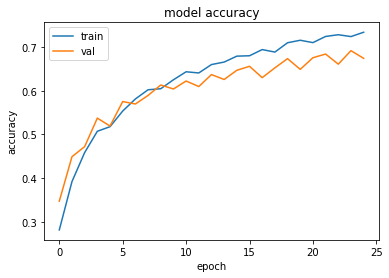

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

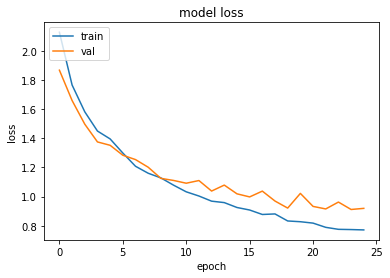

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

104/104 [==============================] - 111s 1s/step - loss: 0.6874 - accuracy: 0.7726
Test loss: 0.9193218946456909    Test accuracy: 0.6743859648704529
Train loss: 0.6874120831489563    Train accuracy: 0.7726315855979919


## Resnet 50

In [ ]:
from keras.applications import ResNet152V2
# Instantiate a ResNet50 model with pre-trained weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.0436248779297 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
104/104 [==============================] - 188s 2s/step - loss: 1.0349 - accuracy: 0.6595 - val_loss: 0.6320 - val_accuracy: 0.7986
Epoch 2/25
104/104 [==============================] - 171s 2s/step - loss: 0.4500 - accuracy: 0.8526 - val_loss: 0.5652 - val_accuracy: 0.8056
Epoch 3/25
104/104 [==============================] - 169s 2s/step - loss: 0.3082 - accuracy: 0.8899 - val_loss: 0.5455 - val_accuracy: 0.8204
Epoch 4/25
104/104 [==============================] - 168s 2s/step - loss: 0.2150 - accuracy: 0.9260 - val_loss: 0.4895 - val_accuracy: 0.8372
Epoch 5/25
104/104 [==============================] - 168s 2s/step - loss: 0.1627 - accuracy: 0.9465 - val_loss: 0.5467 - val_accuracy: 0.8267
Epoch 6/25
104/104 [==============================] - 168s 2s/step - loss: 0.1270 - accuracy: 0.9588 - val_loss: 0.5768 - val_accuracy: 0.8246
Epoch 7/25
104/104 [==============================] - 168s 2s/step - loss: 0.0957 - accuracy: 0.9720 - val_loss: 0.5660 - val_accuracy: 0.8204

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

248.15567016601562 MB


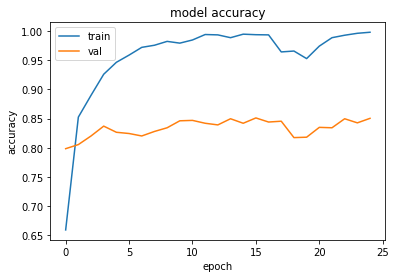

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


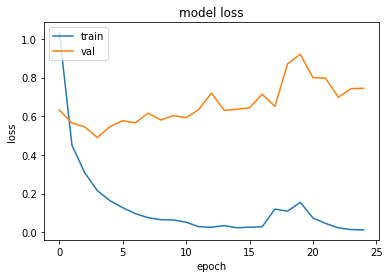

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 120s 1s/step - loss: 0.0018 - accuracy: 1.0000
Test loss: 0.7449023723602295    Test accuracy: 0.8505263328552246
Train loss: 0.0017550501506775618    Train accuracy: 1.0


## INCEPTION V3

In [ ]:
from keras.applications import InceptionV3
# Instantiate a InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")


92.0603256225586 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 43s 368ms/step - loss: 1.4066 - accuracy: 0.5546 - val_loss: 0.9428 - val_accuracy: 0.6737
Epoch 2/25
104/104 [==============================] - 36s 349ms/step - loss: 0.6864 - accuracy: 0.7606 - val_loss: 0.8371 - val_accuracy: 0.7158
Epoch 3/25
104/104 [==============================] - 36s 343ms/step - loss: 0.5335 - accuracy: 0.8141 - val_loss: 0.7060 - val_accuracy: 0.7495
Epoch 4/25
104/104 [==============================] - 36s 343ms/step - loss: 0.4302 - accuracy: 0.8460 - val_loss: 0.6790 - val_accuracy: 0.7642
Epoch 5/25
104/104 [==============================] - 36s 343ms/step - loss: 0.3781 - accuracy: 0.8710 - val_loss: 0.6084 - val_accuracy: 0.7979
Epoch 6/25
104/104 [==============================] - 36s 345ms/step - loss: 0.3128 - accuracy: 0.8839 - val_loss: 0.6650 - val_accuracy: 0.7888
Epoch 7/25
104/104 [==============================] - 36s 344ms/step - loss: 0.2600 - accuracy: 0.9092 - val_loss: 0.6023 - val_ac

In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")



108.17230224609375 MB


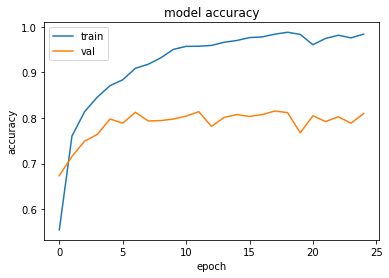

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


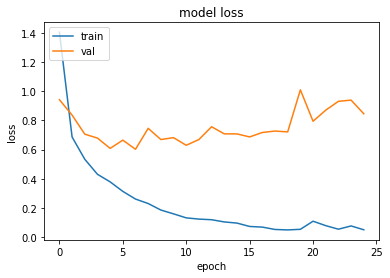

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 27s 261ms/step - loss: 0.0190 - accuracy: 0.9961
Test loss: 0.845984160900116    Test accuracy: 0.8098245859146118
Train loss: 0.01898125559091568    Train accuracy: 0.9960902333259583


## XCEPTION

In [ ]:
from keras.applications import Xception
# Instantiate a Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")


88.02407836914062 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 84s 783ms/step - loss: 1.2323 - accuracy: 0.5862 - val_loss: 0.8201 - val_accuracy: 0.7333
Epoch 2/25
104/104 [==============================] - 78s 749ms/step - loss: 0.6546 - accuracy: 0.7714 - val_loss: 0.7247 - val_accuracy: 0.7572
Epoch 3/25
104/104 [==============================] - 79s 761ms/step - loss: 0.4832 - accuracy: 0.8391 - val_loss: 0.7869 - val_accuracy: 0.7439
Epoch 4/25
104/104 [==============================] - 77s 746ms/step - loss: 0.3963 - accuracy: 0.8698 - val_loss: 0.7350 - val_accuracy: 0.7586
Epoch 5/25
104/104 [==============================] - 77s 745ms/step - loss: 0.2966 - accuracy: 0.9002 - val_loss: 0.6304 - val_accuracy: 0.7902
Epoch 6/25
104/104 [==============================] - 77s 743ms/step - loss: 0.2546 - accuracy: 0.9155 - val_loss: 0.6718 - val_accuracy: 0.7888
Epoch 7/25
104/104 [==============================] - 77s 743ms/step - loss: 0.1907 - accuracy: 0.9408 - val_loss: 0.6871 - val_ac

In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")



104.13621520996094 MB


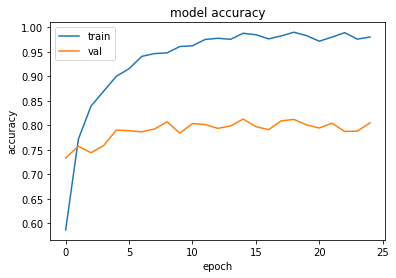

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


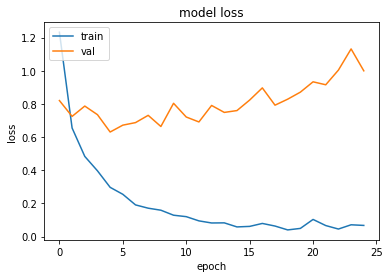

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 58s 554ms/step - loss: 0.0208 - accuracy: 0.9967
Test loss: 0.9995696544647217    Test accuracy: 0.804912269115448
Train loss: 0.02084897644817829    Train accuracy: 0.9966917037963867


## **DenseNet121**

In [ ]:
from keras.applications import DenseNet121
# Instantiate a DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")


32.02589416503906 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 102s 912ms/step - loss: 1.2822 - accuracy: 0.5862 - val_loss: 0.7593 - val_accuracy: 0.7572
Epoch 2/25
104/104 [==============================] - 92s 891ms/step - loss: 0.6691 - accuracy: 0.7720 - val_loss: 0.6915 - val_accuracy: 0.7319
Epoch 3/25
104/104 [==============================] - 91s 880ms/step - loss: 0.5253 - accuracy: 0.8256 - val_loss: 0.5298 - val_accuracy: 0.8189
Epoch 4/25
104/104 [==============================] - 92s 888ms/step - loss: 0.4301 - accuracy: 0.8568 - val_loss: 0.4871 - val_accuracy: 0.8386
Epoch 5/25
104/104 [==============================] - 92s 889ms/step - loss: 0.3622 - accuracy: 0.8785 - val_loss: 0.5104 - val_accuracy: 0.8253
Epoch 6/25
104/104 [==============================] - 92s 885ms/step - loss: 0.3353 - accuracy: 0.8842 - val_loss: 0.5960 - val_accuracy: 0.8035
Epoch 7/25
104/104 [==============================] - 92s 890ms/step - loss: 0.3053 - accuracy: 0.8989 - val_loss: 0.4541 - val_a

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



40.13800811767578 MB


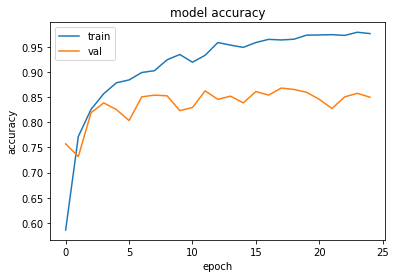

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


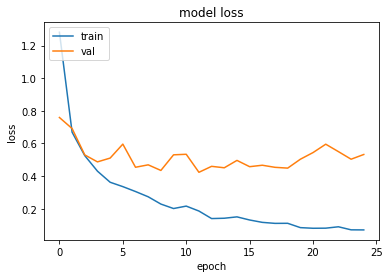

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 62s 594ms/step - loss: 0.0507 - accuracy: 0.9880
Test loss: 0.5324544310569763    Test accuracy: 0.8498245477676392
Train loss: 0.05073763430118561    Train accuracy: 0.9879699349403381


### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2
# Instantiate a DenseNet121 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('MobileNetV2_0129.h5')


print(os.path.getsize("MobileNetV2_0129.h5")/1048576, "MB")


14.125572204589844 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 33s 286ms/step - loss: 1.2230 - accuracy: 0.6102 - val_loss: 0.7785 - val_accuracy: 0.7284
Epoch 2/25
104/104 [==============================] - 28s 271ms/step - loss: 0.6048 - accuracy: 0.7922 - val_loss: 0.5785 - val_accuracy: 0.8000
Epoch 3/25
104/104 [==============================] - 29s 278ms/step - loss: 0.4323 - accuracy: 0.8538 - val_loss: 0.4834 - val_accuracy: 0.8358
Epoch 4/25
104/104 [==============================] - 28s 268ms/step - loss: 0.3538 - accuracy: 0.8782 - val_loss: 0.4592 - val_accuracy: 0.8442
Epoch 5/25
104/104 [==============================] - 27s 257ms/step - loss: 0.2870 - accuracy: 0.9023 - val_loss: 0.4794 - val_accuracy: 0.8393
Epoch 6/25
104/104 [==============================] - 27s 263ms/step - loss: 0.2310 - accuracy: 0.9176 - val_loss: 0.4991 - val_accuracy: 0.8302
Epoch 7/25
104/104 [==============================] - 27s 259ms/step - loss: 0.2049 - accuracy: 0.9251 - val_loss: 0.4777 - val_ac

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



24.23772430419922 MB


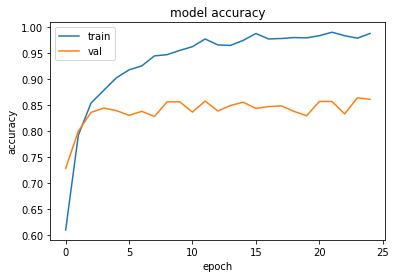

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


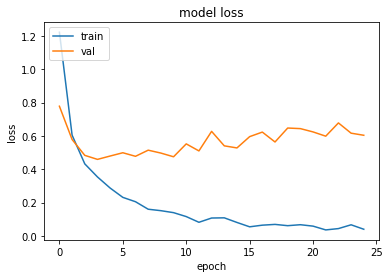

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 20s 192ms/step - loss: 0.0079 - accuracy: 0.9997
Test loss: 0.6040815711021423    Test accuracy: 0.8610526323318481
Train loss: 0.007851434871554375    Train accuracy: 0.9996992349624634


## **Predict train model**

In [ ]:
predictions = model.predict(X_test)

45/45 [==============================] - 10s 205ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

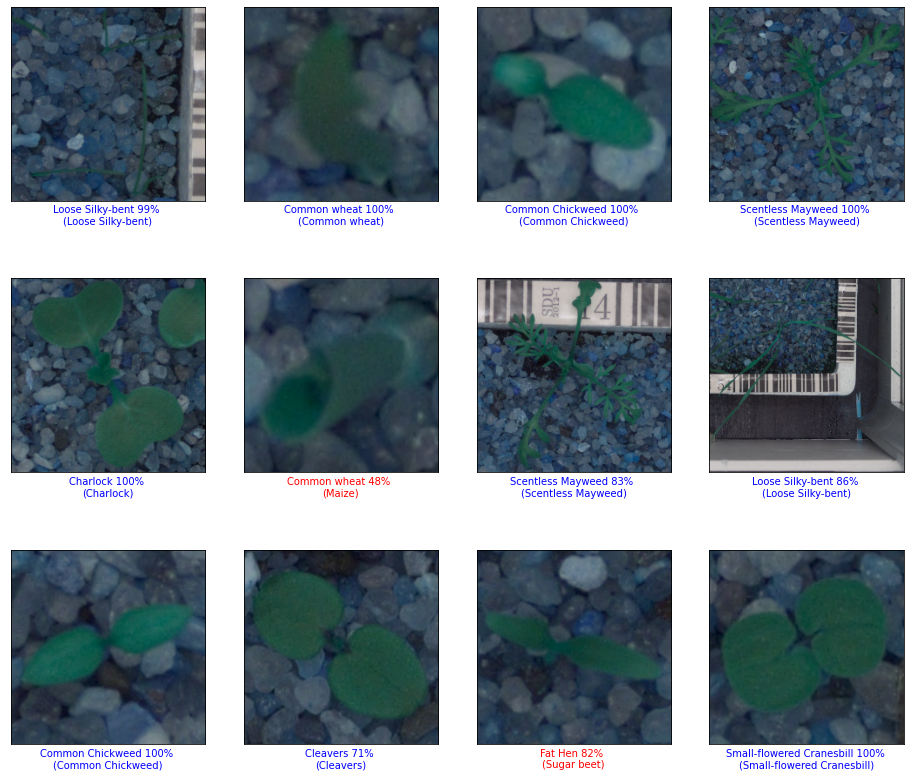

In [ ]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()